# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import json

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import *
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-22 21:12:14.835214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 21:12:14.865628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-22 21:12:15.819730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 21:12:15.823672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 21:12:15.823813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 200
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-22 21:12:15.848137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 21:12:15.848322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 21:12:15.848436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-22 21:12:19.736743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


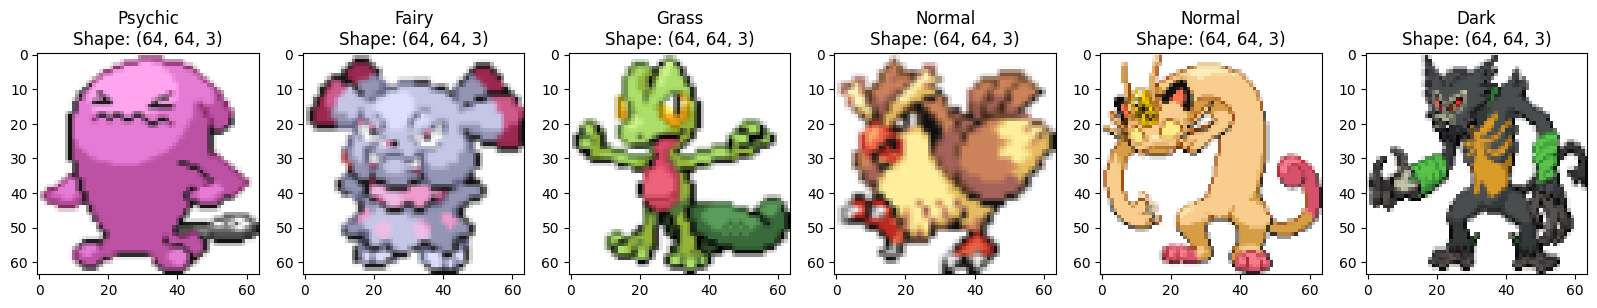

2024-04-22 21:12:20.322991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


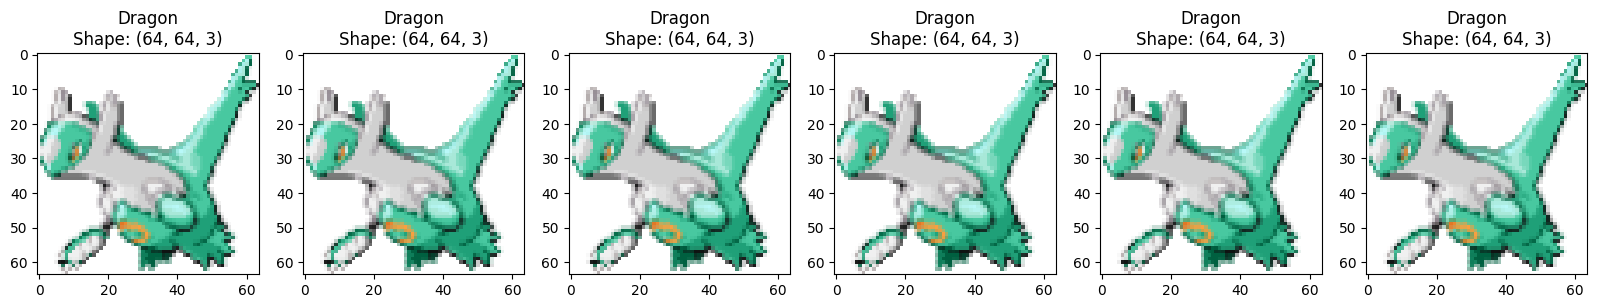

2024-04-22 21:13:39.614866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-22 21:13:39.615631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [72]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(512).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [73]:
label_example

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

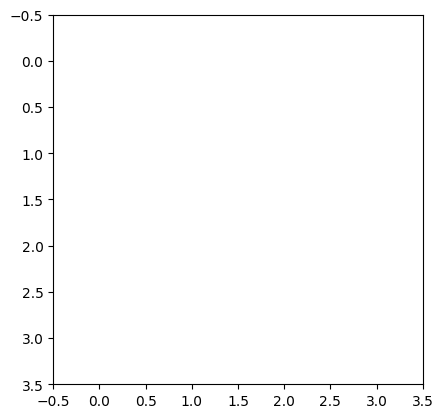

In [74]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 30
h = 30

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [75]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-22 21:13:49.992058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-22 21:13:51.993941: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - loss: 1.1017
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.7823
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.6159
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.4747
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.2881
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1975
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.2615
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.2919
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1384
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.2604Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 22.74it/s]


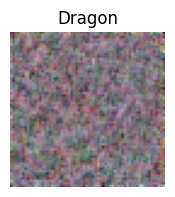

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 927ms/step - loss: 0.2451
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1631
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.2449
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1936
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0938
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1480
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1590
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.2737
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1557
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1442
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3509Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.52it/s]


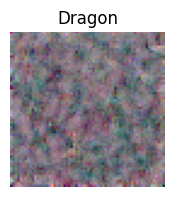

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - loss: 0.3303
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.1849
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0793
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1182
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1044
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0862
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0896
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0737
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1361
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1238
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1824Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.55it/s]


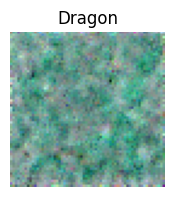

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - loss: 0.1717
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1136
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.1709
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.2022
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.3308
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1293
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0971
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0958
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0662
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0845
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0727Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.26it/s]


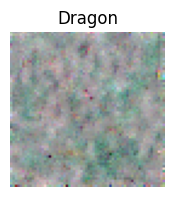

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - loss: 0.0684
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.1322
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0850
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0858
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1113
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1204
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1757
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1599
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0900
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0839
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.1069Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 22.34it/s]


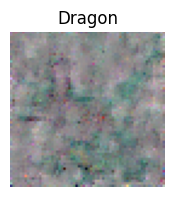

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 951ms/step - loss: 0.1006
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0508
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1268
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0901
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0691
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0993
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1267
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1031
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0782
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1005
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.0839Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.24it/s]


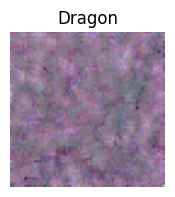

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 927ms/step - loss: 0.0790
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0644
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0753
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0830
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0721
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0990
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0758
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0388
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0544
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0813
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0809Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 22.17it/s]


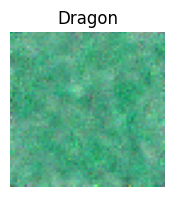

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 952ms/step - loss: 0.0762
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.1371
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1475
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1492
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0807
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0650
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0578
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 0.0260
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0511
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0493
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1084Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.02it/s]


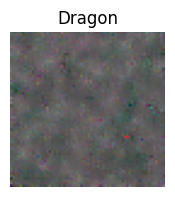

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 925ms/step - loss: 0.1021
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.2244
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.2114
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1060
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0902
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0871
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0889
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0543
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0528
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0716
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0925Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.86it/s]


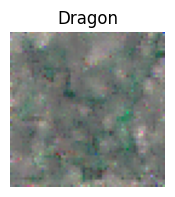

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0871
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0604
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0909
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0661
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0494
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0260
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0274
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0611
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0419
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1028
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0760Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.40it/s]


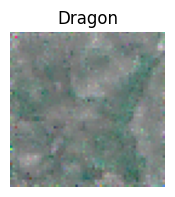

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0716


In [76]:
tf.config.run_functions_eagerly(True)  # to debug the model
# model.fit(
#     dataset_example,
#     epochs=EPOCHS,
#     callbacks=[PlottingCallback(model, 6), DiffusionCallback(model, 20, "Electric")],
# )
str_label_example = onehot_to_string(label_example)
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0544
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0725
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0603
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0631
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0491
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0576
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0943
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0404
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1566
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0580Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.12it/s]


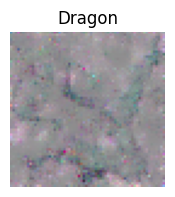

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - loss: 0.0546
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0851
Epoch 12/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0770
Epoch 13/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0609
Epoch 14/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0780
Epoch 15/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0424
Epoch 16/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0504
Epoch 17/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0667
Epoch 18/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0591
Epoch 19/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0973
Epoch 20/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0861Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.96it/s]


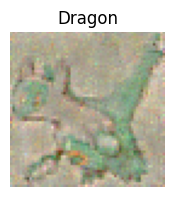

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - loss: 0.0810
Epoch 21/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0821
Epoch 22/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.1390
Epoch 23/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0889
Epoch 24/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0470
Epoch 25/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0343
Epoch 26/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0298
Epoch 27/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0871
Epoch 28/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0308
Epoch 29/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0231
Epoch 30/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0272Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.37it/s]


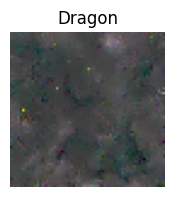

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 891ms/step - loss: 0.0256
Epoch 31/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0359
Epoch 32/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0372
Epoch 33/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0346
Epoch 34/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0395
Epoch 35/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0464
Epoch 36/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0299
Epoch 37/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0355
Epoch 38/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0371
Epoch 39/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0739
Epoch 40/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0590Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.41it/s]


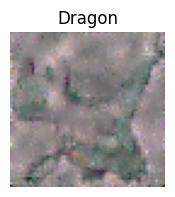

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - loss: 0.0555
Epoch 41/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1485
Epoch 42/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0986
Epoch 43/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.1078
Epoch 44/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1031
Epoch 45/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1027
Epoch 46/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0452
Epoch 47/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0454
Epoch 48/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0353
Epoch 49/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0722
Epoch 50/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0766Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.42it/s]


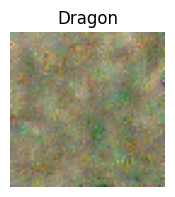

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 912ms/step - loss: 0.0720
Epoch 51/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0436
Epoch 52/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0291
Epoch 53/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0379
Epoch 54/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0555
Epoch 55/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0537
Epoch 56/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1100
Epoch 57/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.2451
Epoch 58/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0725
Epoch 59/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0507
Epoch 60/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0226Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.13it/s]


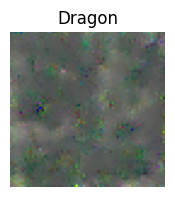

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - loss: 0.0213
Epoch 61/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0400
Epoch 62/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0814
Epoch 63/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0491
Epoch 64/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0278
Epoch 65/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0381
Epoch 66/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0283
Epoch 67/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0235
Epoch 68/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0224
Epoch 69/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0224
Epoch 70/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0196Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.72it/s]


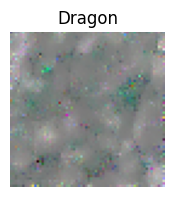

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 882ms/step - loss: 0.0185
Epoch 71/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0308
Epoch 72/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0776
Epoch 73/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0210
Epoch 74/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0740
Epoch 75/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1188
Epoch 76/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0369
Epoch 77/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0390
Epoch 78/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0771
Epoch 79/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0577
Epoch 80/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0551Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.27it/s]


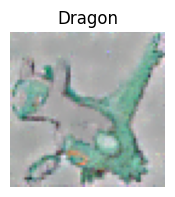

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - loss: 0.0519
Epoch 81/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0232
Epoch 82/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0297
Epoch 83/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0419
Epoch 84/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0319
Epoch 85/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0529
Epoch 86/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0705
Epoch 87/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1288
Epoch 88/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0836
Epoch 89/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0806
Epoch 90/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1119Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.09it/s]


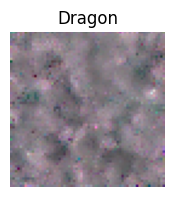

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - loss: 0.1053
Epoch 91/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0373
Epoch 92/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0740
Epoch 93/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0688
Epoch 94/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0740
Epoch 95/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0835
Epoch 96/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0842
Epoch 97/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0564
Epoch 98/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0400
Epoch 99/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0542
Epoch 100/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0648Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.17it/s]


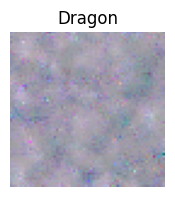

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - loss: 0.0610
Epoch 101/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0313
Epoch 102/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0626
Epoch 103/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0298
Epoch 104/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0754
Epoch 105/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0579
Epoch 106/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0248
Epoch 107/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0406
Epoch 108/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0518
Epoch 109/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0631
Epoch 110/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0346Epoch 110: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.11it/s]


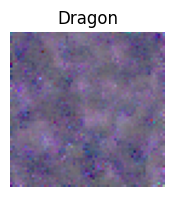

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step - loss: 0.0326
Epoch 111/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0323
Epoch 112/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0461
Epoch 113/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0477
Epoch 114/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0470
Epoch 115/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0362
Epoch 116/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0822
Epoch 117/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1096
Epoch 118/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1869
Epoch 119/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0522
Epoch 120/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0401Epoch 120: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.86it/s]


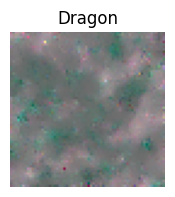

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - loss: 0.0377
Epoch 121/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0652
Epoch 122/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0322
Epoch 123/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0408
Epoch 124/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0558
Epoch 125/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0305
Epoch 126/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0252
Epoch 127/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0424
Epoch 128/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0324
Epoch 129/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0518
Epoch 130/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0386Epoch 130: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.94it/s]


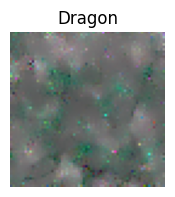

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0364
Epoch 131/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0396
Epoch 132/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0279
Epoch 133/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0235
Epoch 134/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0165
Epoch 135/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0330
Epoch 136/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1253
Epoch 137/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0500
Epoch 138/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0482
Epoch 139/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0849
Epoch 140/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0612Epoch 140: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.18it/s]


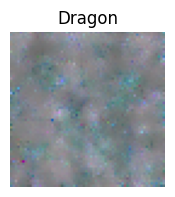

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 892ms/step - loss: 0.0576
Epoch 141/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0246
Epoch 142/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0245
Epoch 143/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0169
Epoch 144/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0270
Epoch 145/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0812
Epoch 146/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0341
Epoch 147/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0170
Epoch 148/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0371
Epoch 149/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0604
Epoch 150/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0235Epoch 150: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.61it/s]


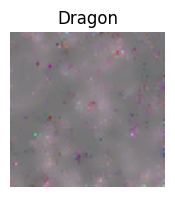

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - loss: 0.0221
Epoch 151/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0198
Epoch 152/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0186
Epoch 153/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1306
Epoch 154/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0426
Epoch 155/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0175
Epoch 156/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1336
Epoch 157/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1285
Epoch 158/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0368
Epoch 159/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0699
Epoch 160/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0662Epoch 160: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.50it/s]


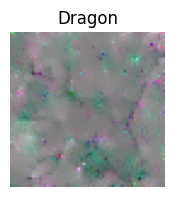

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 912ms/step - loss: 0.0623
Epoch 161/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1157
Epoch 162/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0498
Epoch 163/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0553
Epoch 164/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0198
Epoch 165/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0399
Epoch 166/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0299
Epoch 167/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0245
Epoch 168/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0259
Epoch 169/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0558
Epoch 170/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0250Epoch 170: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.58it/s]


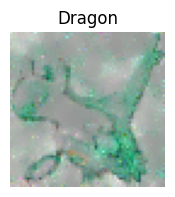

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - loss: 0.0236
Epoch 171/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0357
Epoch 172/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0364
Epoch 173/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0316
Epoch 174/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0505
Epoch 175/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0156
Epoch 176/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0246
Epoch 177/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0368
Epoch 178/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0300
Epoch 179/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0213
Epoch 180/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0215Epoch 180: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.26it/s]


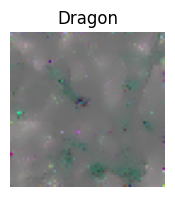

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - loss: 0.0203
Epoch 181/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0218
Epoch 182/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0155
Epoch 183/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0215
Epoch 184/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0173
Epoch 185/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0444
Epoch 186/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0187
Epoch 187/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0175
Epoch 188/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0203
Epoch 189/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0228
Epoch 190/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0142Epoch 190: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.79it/s]


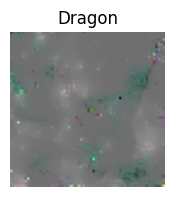

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0134
Epoch 191/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0228
Epoch 192/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0234
Epoch 193/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0461
Epoch 194/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0697
Epoch 195/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0680
Epoch 196/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1449
Epoch 197/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0869
Epoch 198/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0432
Epoch 199/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0545
Epoch 200/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0294Epoch 200: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.27it/s]


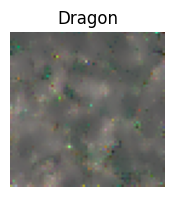

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.0277
Epoch 201/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0410
Epoch 202/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0760
Epoch 203/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1563
Epoch 204/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0362
Epoch 205/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0528
Epoch 206/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0633
Epoch 207/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0291
Epoch 208/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0664
Epoch 209/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0482
Epoch 210/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0393Epoch 210: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.36it/s]


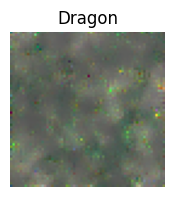

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0370
Epoch 211/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0715
Epoch 212/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.2585
Epoch 213/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1441
Epoch 214/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1247
Epoch 215/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0622
Epoch 216/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0452
Epoch 217/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0534
Epoch 218/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0481
Epoch 219/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0176
Epoch 220/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0494Epoch 220: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.28it/s]


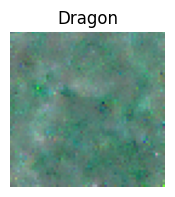

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0465
Epoch 221/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.1016
Epoch 222/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0606
Epoch 223/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0318
Epoch 224/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0710
Epoch 225/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1120
Epoch 226/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0179
Epoch 227/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0306
Epoch 228/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0244
Epoch 229/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0242
Epoch 230/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0226Epoch 230: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.68it/s]


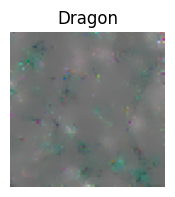

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0212
Epoch 231/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0219
Epoch 232/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0200
Epoch 233/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0235
Epoch 234/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0310
Epoch 235/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0152
Epoch 236/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0569
Epoch 237/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0177
Epoch 238/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0746
Epoch 239/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0233
Epoch 240/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0318Epoch 240: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.21it/s]


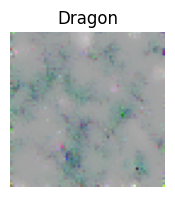

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 923ms/step - loss: 0.0299
Epoch 241/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0275
Epoch 242/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0199
Epoch 243/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0449
Epoch 244/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0619
Epoch 245/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0442
Epoch 246/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0172
Epoch 247/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0184
Epoch 248/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0312
Epoch 249/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0145
Epoch 250/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0227Epoch 250: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.91it/s]


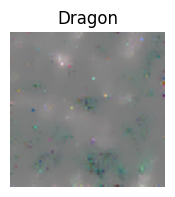

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0213
Epoch 251/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0142
Epoch 252/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0233
Epoch 253/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0284
Epoch 254/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0260
Epoch 255/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0490
Epoch 256/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0904
Epoch 257/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0433
Epoch 258/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.2398
Epoch 259/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0553
Epoch 260/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.2116Epoch 260: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.82it/s]


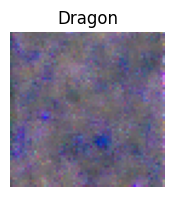

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.1991
Epoch 261/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0317
Epoch 262/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0593
Epoch 263/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0377
Epoch 264/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0152
Epoch 265/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0201
Epoch 266/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0203
Epoch 267/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0164
Epoch 268/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0292
Epoch 269/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0354
Epoch 270/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0428Epoch 270: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.57it/s]


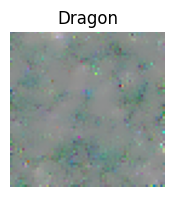

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - loss: 0.0403
Epoch 271/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0236
Epoch 272/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0187
Epoch 273/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0274
Epoch 274/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0582
Epoch 275/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0384
Epoch 276/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0389
Epoch 277/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0554
Epoch 278/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0203
Epoch 279/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0316
Epoch 280/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0351Epoch 280: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.68it/s]


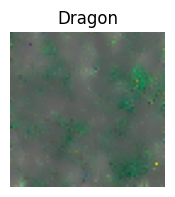

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 905ms/step - loss: 0.0331
Epoch 281/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0497
Epoch 282/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0574
Epoch 283/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0688
Epoch 284/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1742
Epoch 285/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0414
Epoch 286/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0304
Epoch 287/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0256
Epoch 288/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0475
Epoch 289/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0185
Epoch 290/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0161Epoch 290: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.81it/s]


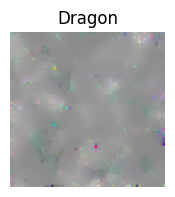

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - loss: 0.0152
Epoch 291/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0196
Epoch 292/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0125
Epoch 293/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0696
Epoch 294/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0255
Epoch 295/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0255
Epoch 296/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0184
Epoch 297/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0162
Epoch 298/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0148
Epoch 299/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0228
Epoch 300/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0273Epoch 300: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.43it/s]


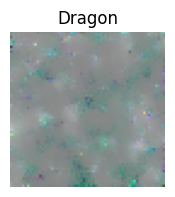

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0257
Epoch 301/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0130
Epoch 302/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0299
Epoch 303/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0514
Epoch 304/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0595
Epoch 305/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0722
Epoch 306/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0671
Epoch 307/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0891
Epoch 308/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0397
Epoch 309/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0438
Epoch 310/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0316Epoch 310: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.08it/s]


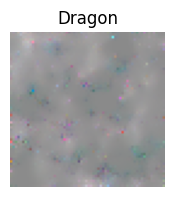

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step - loss: 0.0297
Epoch 311/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0138
Epoch 312/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0481
Epoch 313/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0271
Epoch 314/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0126
Epoch 315/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0186
Epoch 316/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0273
Epoch 317/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0499
Epoch 318/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0325
Epoch 319/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0262
Epoch 320/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0292Epoch 320: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.79it/s]


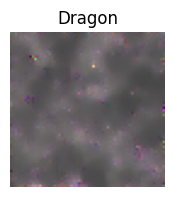

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0275
Epoch 321/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0154
Epoch 322/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0109
Epoch 323/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0156
Epoch 324/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0417
Epoch 325/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0198
Epoch 326/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0295
Epoch 327/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0813
Epoch 328/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0347
Epoch 329/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0255
Epoch 330/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0127Epoch 330: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.73it/s]


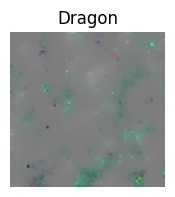

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0120
Epoch 331/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0102
Epoch 332/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0330
Epoch 333/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0157
Epoch 334/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0229
Epoch 335/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0445
Epoch 336/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0207
Epoch 337/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0110
Epoch 338/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0151
Epoch 339/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0119
Epoch 340/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0111Epoch 340: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.57it/s]


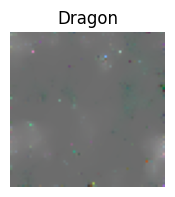

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 905ms/step - loss: 0.0105
Epoch 341/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0098
Epoch 342/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0248
Epoch 343/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0369
Epoch 344/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0774
Epoch 345/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0833
Epoch 346/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0751
Epoch 347/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0439
Epoch 348/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0535
Epoch 349/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0336
Epoch 350/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1034Epoch 350: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.89it/s]


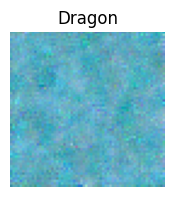

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 905ms/step - loss: 0.0974
Epoch 351/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0556
Epoch 352/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0299
Epoch 353/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0748
Epoch 354/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0636
Epoch 355/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0884
Epoch 356/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0251
Epoch 357/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0130
Epoch 358/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0565
Epoch 359/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0412
Epoch 360/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0150Epoch 360: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.82it/s]


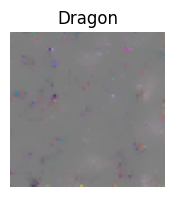

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 905ms/step - loss: 0.0141
Epoch 361/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0132
Epoch 362/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0172
Epoch 363/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0116
Epoch 364/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0195
Epoch 365/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0229
Epoch 366/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0110
Epoch 367/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0856
Epoch 368/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0649
Epoch 369/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0398
Epoch 370/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0706Epoch 370: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.95it/s]


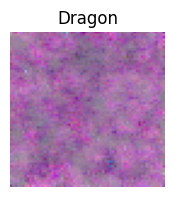

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - loss: 0.0664
Epoch 371/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0276
Epoch 372/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0169
Epoch 373/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0227
Epoch 374/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0247
Epoch 375/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0150
Epoch 376/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0157
Epoch 377/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0127
Epoch 378/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0123
Epoch 379/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0234
Epoch 380/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0277Epoch 380: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.91it/s]


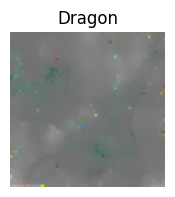

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - loss: 0.0261
Epoch 381/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0309
Epoch 382/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0288
Epoch 383/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0277
Epoch 384/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0343
Epoch 385/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0931
Epoch 386/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0548
Epoch 387/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0687
Epoch 388/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0392
Epoch 389/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0287
Epoch 390/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0171Epoch 390: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.25it/s]


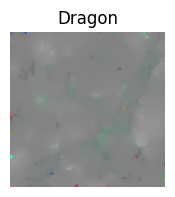

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0161
Epoch 391/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0099
Epoch 392/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0133
Epoch 393/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0123
Epoch 394/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0132
Epoch 395/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0484
Epoch 396/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0109
Epoch 397/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0413
Epoch 398/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1462
Epoch 399/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0245
Epoch 400/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0219Epoch 400: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.90it/s]


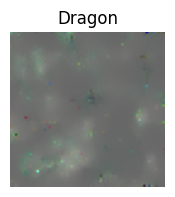

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - loss: 0.0206
Epoch 401/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0175
Epoch 402/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0229
Epoch 403/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0158
Epoch 404/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0232
Epoch 405/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0128
Epoch 406/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0378
Epoch 407/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0118
Epoch 408/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0217
Epoch 409/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0139
Epoch 410/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0142Epoch 410: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.83it/s]


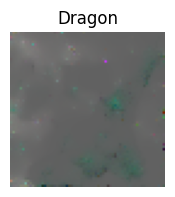

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - loss: 0.0133
Epoch 411/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0356
Epoch 412/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0162
Epoch 413/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0186
Epoch 414/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0153
Epoch 415/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0199
Epoch 416/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0211
Epoch 417/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0205
Epoch 418/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0115
Epoch 419/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0100
Epoch 420/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0094Epoch 420: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.81it/s]


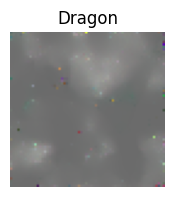

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - loss: 0.0088
Epoch 421/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0079
Epoch 422/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0102
Epoch 423/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0242
Epoch 424/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0593
Epoch 425/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0353
Epoch 426/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0696
Epoch 427/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0321
Epoch 428/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0125
Epoch 429/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0198
Epoch 430/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0678Epoch 430: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.20it/s]


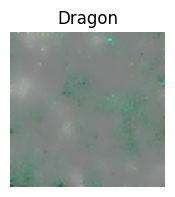

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - loss: 0.0638
Epoch 431/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0293
Epoch 432/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0251
Epoch 433/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0274
Epoch 434/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0218
Epoch 435/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0120
Epoch 436/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0574
Epoch 437/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0185
Epoch 438/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0597
Epoch 439/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0358
Epoch 440/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0256Epoch 440: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.84it/s]


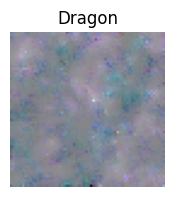

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - loss: 0.0241
Epoch 441/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0136
Epoch 442/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0101
Epoch 443/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0109
Epoch 444/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0129
Epoch 445/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0152
Epoch 446/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0344
Epoch 447/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1023
Epoch 448/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0648
Epoch 449/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0360
Epoch 450/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0362Epoch 450: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.58it/s]


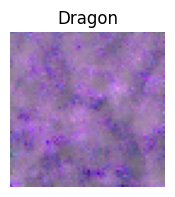

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - loss: 0.0341
Epoch 451/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0214
Epoch 452/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0202
Epoch 453/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0098
Epoch 454/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0284
Epoch 455/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0184
Epoch 456/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0111
Epoch 457/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0172
Epoch 458/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0108
Epoch 459/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0197
Epoch 460/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0128Epoch 460: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.23it/s]


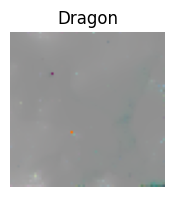

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 921ms/step - loss: 0.0120
Epoch 461/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0076
Epoch 462/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0155
Epoch 463/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0130
Epoch 464/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0088
Epoch 465/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0072
Epoch 466/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0224
Epoch 467/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0276
Epoch 468/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0378
Epoch 469/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0185
Epoch 470/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0201Epoch 470: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.73it/s]


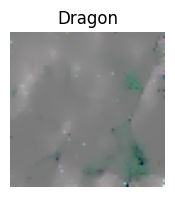

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0189
Epoch 471/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0141
Epoch 472/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1854
Epoch 473/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1491
Epoch 474/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0533
Epoch 475/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0457
Epoch 476/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0494
Epoch 477/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0594
Epoch 478/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0535
Epoch 479/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0280
Epoch 480/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0402Epoch 480: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.70it/s]


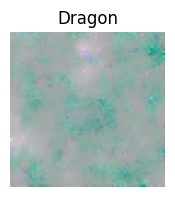

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - loss: 0.0378
Epoch 481/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0177
Epoch 482/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0654
Epoch 483/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0265
Epoch 484/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0708
Epoch 485/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0636
Epoch 486/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0166
Epoch 487/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0113
Epoch 488/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0534
Epoch 489/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0609
Epoch 490/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0350Epoch 490: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.79it/s]


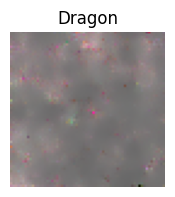

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0329
Epoch 491/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0325
Epoch 492/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0410
Epoch 493/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0192
Epoch 494/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0284
Epoch 495/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0275
Epoch 496/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0432
Epoch 497/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0207
Epoch 498/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0262
Epoch 499/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0136
Epoch 500/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0128Epoch 500: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.48it/s]


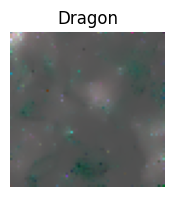

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0120
Epoch 501/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0098
Epoch 502/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0437
Epoch 503/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0414
Epoch 504/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0297
Epoch 505/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0260
Epoch 506/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0229
Epoch 507/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0445
Epoch 508/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0542
Epoch 509/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0253
Epoch 510/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0237Epoch 510: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.93it/s]


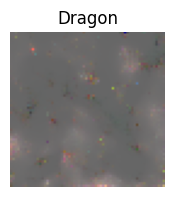

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - loss: 0.0223
Epoch 511/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0459
Epoch 512/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0192
Epoch 513/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.3310
Epoch 514/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0584
Epoch 515/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0426
Epoch 516/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0288
Epoch 517/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0163
Epoch 518/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0108
Epoch 519/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0184
Epoch 520/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0333Epoch 520: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.38it/s]


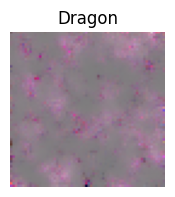

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 915ms/step - loss: 0.0314
Epoch 521/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0174
Epoch 522/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1113
Epoch 523/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0704
Epoch 524/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0328
Epoch 525/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0170
Epoch 526/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0311
Epoch 527/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0165
Epoch 528/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0198
Epoch 529/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0096
Epoch 530/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0134Epoch 530: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.53it/s]


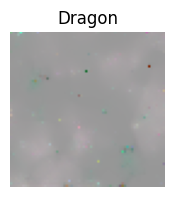

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0126
Epoch 531/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0108
Epoch 532/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0119
Epoch 533/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0381
Epoch 534/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0896
Epoch 535/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0199
Epoch 536/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0401
Epoch 537/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0148
Epoch 538/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0145
Epoch 539/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0143
Epoch 540/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0204Epoch 540: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.81it/s]


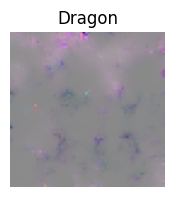

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - loss: 0.0192
Epoch 541/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0181
Epoch 542/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0193
Epoch 543/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0113
Epoch 544/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0167
Epoch 545/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0101
Epoch 546/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0089
Epoch 547/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1047
Epoch 548/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0238
Epoch 549/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0482
Epoch 550/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0091Epoch 550: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.49it/s]


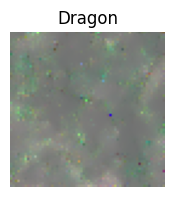

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 915ms/step - loss: 0.0086
Epoch 551/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0105
Epoch 552/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0172
Epoch 553/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0517
Epoch 554/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0111
Epoch 555/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0131
Epoch 556/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0219
Epoch 557/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0107
Epoch 558/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0071
Epoch 559/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0099
Epoch 560/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0132Epoch 560: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.51it/s]


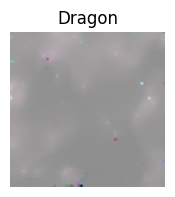

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0124
Epoch 561/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0147
Epoch 562/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0185
Epoch 563/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0086
Epoch 564/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0088
Epoch 565/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0191
Epoch 566/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0359
Epoch 567/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0246
Epoch 568/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0173
Epoch 569/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0318
Epoch 570/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0357Epoch 570: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.84it/s]


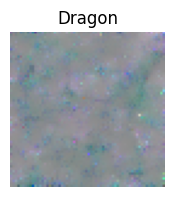

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0336
Epoch 571/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0362
Epoch 572/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0272
Epoch 573/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0181
Epoch 574/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0198
Epoch 575/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0126
Epoch 576/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0078
Epoch 577/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0481
Epoch 578/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0256
Epoch 579/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0737
Epoch 580/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0272Epoch 580: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.25it/s]


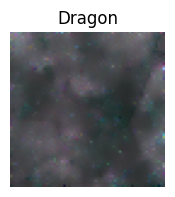

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 919ms/step - loss: 0.0256
Epoch 581/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1344
Epoch 582/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0637
Epoch 583/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0220
Epoch 584/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0126
Epoch 585/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0112
Epoch 586/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0174
Epoch 587/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0141
Epoch 588/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0164
Epoch 589/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0112
Epoch 590/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0088Epoch 590: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.53it/s]


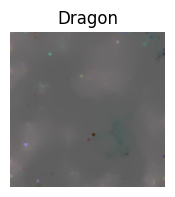

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 915ms/step - loss: 0.0083
Epoch 591/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0121
Epoch 592/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0236
Epoch 593/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0477
Epoch 594/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0162
Epoch 595/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0147
Epoch 596/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0316
Epoch 597/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0352
Epoch 598/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0384
Epoch 599/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0199
Epoch 600/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0087Epoch 600: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.77it/s]


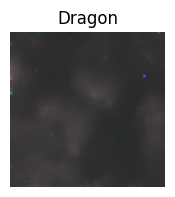

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0082
Epoch 601/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0217
Epoch 602/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0093
Epoch 603/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0074
Epoch 604/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0070
Epoch 605/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0076
Epoch 606/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0101
Epoch 607/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0076
Epoch 608/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0095
Epoch 609/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0083
Epoch 610/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0068Epoch 610: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.78it/s]


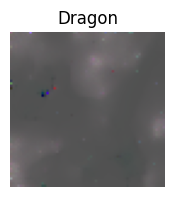

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0064
Epoch 611/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0120
Epoch 612/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0102
Epoch 613/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0231
Epoch 614/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0313
Epoch 615/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0175
Epoch 616/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0486
Epoch 617/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0183
Epoch 618/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0118
Epoch 619/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0153
Epoch 620/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0106Epoch 620: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.09it/s]


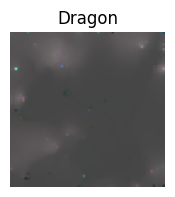

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 922ms/step - loss: 0.0100
Epoch 621/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0176
Epoch 622/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0480
Epoch 623/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0137
Epoch 624/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0132
Epoch 625/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0321
Epoch 626/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0731
Epoch 627/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0251
Epoch 628/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0191
Epoch 629/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0173
Epoch 630/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0413Epoch 630: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.83it/s]


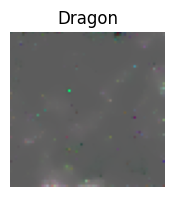

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - loss: 0.0389
Epoch 631/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0118
Epoch 632/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0072
Epoch 633/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0251
Epoch 634/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0166
Epoch 635/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0201
Epoch 636/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0153
Epoch 637/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0079
Epoch 638/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0089
Epoch 639/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0211
Epoch 640/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0469Epoch 640: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.60it/s]


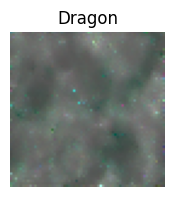

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0441
Epoch 641/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.2076
Epoch 642/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0798
Epoch 643/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0275
Epoch 644/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0298
Epoch 645/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0116
Epoch 646/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0276
Epoch 647/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0273
Epoch 648/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0143
Epoch 649/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0173
Epoch 650/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0137Epoch 650: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.67it/s]


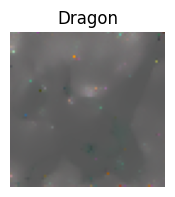

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0129
Epoch 651/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0082
Epoch 652/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0104
Epoch 653/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0099
Epoch 654/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0335
Epoch 655/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0529
Epoch 656/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0193
Epoch 657/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0311
Epoch 658/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0199
Epoch 659/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0451
Epoch 660/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0285Epoch 660: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.69it/s]


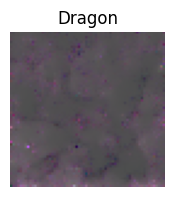

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0268
Epoch 661/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0210
Epoch 662/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0103
Epoch 663/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0484
Epoch 664/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0124
Epoch 665/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0153
Epoch 666/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0105
Epoch 667/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0504
Epoch 668/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0578
Epoch 669/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0308
Epoch 670/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0243Epoch 670: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.23it/s]


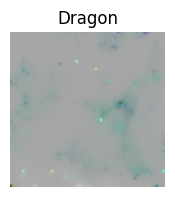

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 920ms/step - loss: 0.0229
Epoch 671/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0168
Epoch 672/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0153
Epoch 673/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0079
Epoch 674/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0066
Epoch 675/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0094
Epoch 676/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0176
Epoch 677/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0343
Epoch 678/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0214
Epoch 679/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0118
Epoch 680/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0225Epoch 680: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.41it/s]


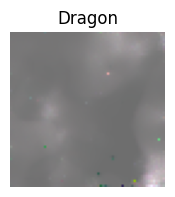

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - loss: 0.0212
Epoch 681/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1170
Epoch 682/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0427
Epoch 683/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0490
Epoch 684/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0316
Epoch 685/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0574
Epoch 686/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0552
Epoch 687/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0257
Epoch 688/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0190
Epoch 689/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0252
Epoch 690/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0275Epoch 690: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.72it/s]


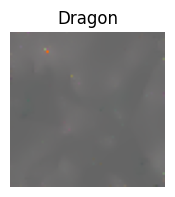

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0259
Epoch 691/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0129
Epoch 692/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0092
Epoch 693/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0464
Epoch 694/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0096
Epoch 695/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0092
Epoch 696/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0063
Epoch 697/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1348
Epoch 698/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1032
Epoch 699/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0590
Epoch 700/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0442Epoch 700: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.34it/s]


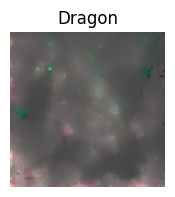

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 919ms/step - loss: 0.0416
Epoch 701/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0116
Epoch 702/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0927
Epoch 703/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0142
Epoch 704/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0092
Epoch 705/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0096
Epoch 706/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0122
Epoch 707/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0083
Epoch 708/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0088
Epoch 709/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0265
Epoch 710/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0351Epoch 710: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.16it/s]


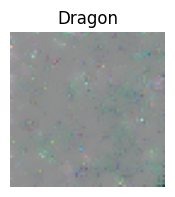

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 918ms/step - loss: 0.0331
Epoch 711/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0328
Epoch 712/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0177
Epoch 713/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0122
Epoch 714/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0176
Epoch 715/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0171
Epoch 716/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0504
Epoch 717/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0799
Epoch 718/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0589
Epoch 719/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0675
Epoch 720/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0456Epoch 720: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.64it/s]


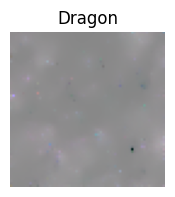

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0429
Epoch 721/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0596
Epoch 722/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0479
Epoch 723/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0227
Epoch 724/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0159
Epoch 725/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0185
Epoch 726/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0070
Epoch 727/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0143
Epoch 728/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0982
Epoch 729/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1220
Epoch 730/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.1280Epoch 730: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.42it/s]


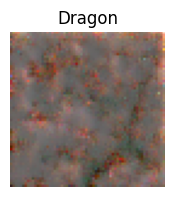

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - loss: 0.1205
Epoch 731/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1330
Epoch 732/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0567
Epoch 733/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0557
Epoch 734/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0540
Epoch 735/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0321
Epoch 736/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0443
Epoch 737/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0140
Epoch 738/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0182
Epoch 739/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0370
Epoch 740/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0178Epoch 740: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.50it/s]


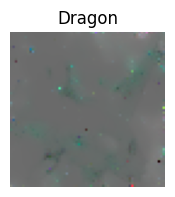

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0167
Epoch 741/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0090
Epoch 742/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0336
Epoch 743/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0081
Epoch 744/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0186
Epoch 745/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0143
Epoch 746/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0072
Epoch 747/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0136
Epoch 748/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0093
Epoch 749/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0096
Epoch 750/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0635Epoch 750: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.56it/s]


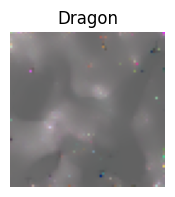

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.0598
Epoch 751/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1466
Epoch 752/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1677
Epoch 753/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0959
Epoch 754/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0690
Epoch 755/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0596
Epoch 756/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0144
Epoch 757/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0219
Epoch 758/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0095
Epoch 759/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0099
Epoch 760/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0150Epoch 760: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.57it/s]


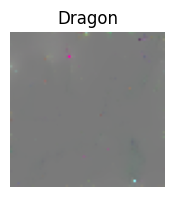

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0141
Epoch 761/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0323
Epoch 762/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0356
Epoch 763/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.2188
Epoch 764/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1570
Epoch 765/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0551
Epoch 766/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0447
Epoch 767/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0198
Epoch 768/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0203
Epoch 769/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0163
Epoch 770/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0128Epoch 770: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.45it/s]


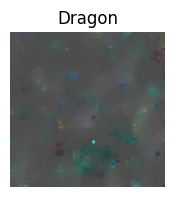

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 915ms/step - loss: 0.0120
Epoch 771/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0442
Epoch 772/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0187
Epoch 773/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0263
Epoch 774/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0283
Epoch 775/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0120
Epoch 776/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0083
Epoch 777/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0271
Epoch 778/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1306
Epoch 779/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0441
Epoch 780/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0166Epoch 780: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.57it/s]


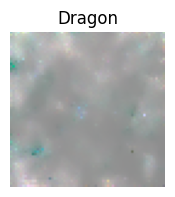

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 0.0156
Epoch 781/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0179
Epoch 782/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0193
Epoch 783/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0112
Epoch 784/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0143
Epoch 785/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0532
Epoch 786/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0384
Epoch 787/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0328
Epoch 788/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0388
Epoch 789/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0379
Epoch 790/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0170Epoch 790: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.68it/s]


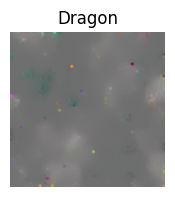

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0160
Epoch 791/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0091
Epoch 792/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0339
Epoch 793/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0107
Epoch 794/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0198
Epoch 795/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0119
Epoch 796/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0100
Epoch 797/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0247
Epoch 798/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0201
Epoch 799/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0134
Epoch 800/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0120Epoch 800: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.38it/s]


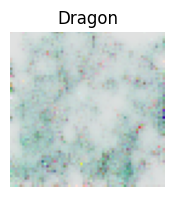

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 916ms/step - loss: 0.0113
Epoch 801/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0220
Epoch 802/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0094
Epoch 803/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0082
Epoch 804/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0434
Epoch 805/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0497
Epoch 806/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.2772
Epoch 807/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1138
Epoch 808/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0975
Epoch 809/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0829
Epoch 810/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0987Epoch 810: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.75it/s]


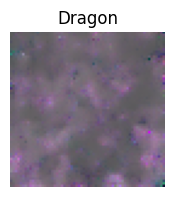

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - loss: 0.0929
Epoch 811/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0215
Epoch 812/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0109
Epoch 813/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0084
Epoch 814/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0120
Epoch 815/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0102
Epoch 816/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0621
Epoch 817/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0093
Epoch 818/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0252
Epoch 819/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0383
Epoch 820/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0092Epoch 820: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.59it/s]


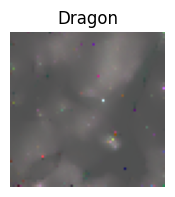

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0087
Epoch 821/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0260
Epoch 822/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0132
Epoch 823/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0373
Epoch 824/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0145
Epoch 825/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0124
Epoch 826/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0285
Epoch 827/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0848
Epoch 828/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0695
Epoch 829/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0180
Epoch 830/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0193Epoch 830: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.71it/s]


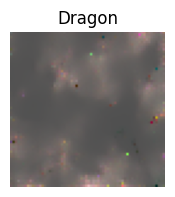

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0182
Epoch 831/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0760
Epoch 832/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0313
Epoch 833/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0107
Epoch 834/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0112
Epoch 835/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0477
Epoch 836/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1341
Epoch 837/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0557
Epoch 838/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0553
Epoch 839/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0773
Epoch 840/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0229Epoch 840: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.71it/s]


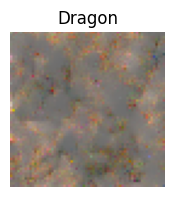

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 905ms/step - loss: 0.0215
Epoch 841/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0119
Epoch 842/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0073
Epoch 843/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0193
Epoch 844/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0241
Epoch 845/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0075
Epoch 846/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0071
Epoch 847/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0085
Epoch 848/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0089
Epoch 849/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0079
Epoch 850/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0074Epoch 850: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.74it/s]


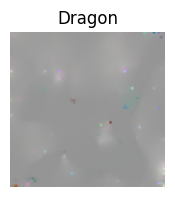

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - loss: 0.0070
Epoch 851/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0233
Epoch 852/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0118
Epoch 853/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0747
Epoch 854/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0224
Epoch 855/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0249
Epoch 856/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0338
Epoch 857/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0288
Epoch 858/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0967
Epoch 859/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0524
Epoch 860/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0312Epoch 860: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.72it/s]


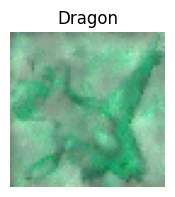

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0294
Epoch 861/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0114
Epoch 862/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0094
Epoch 863/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0097
Epoch 864/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0087
Epoch 865/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0129
Epoch 866/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0721
Epoch 867/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0525
Epoch 868/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0219
Epoch 869/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0613
Epoch 870/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0602Epoch 870: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.34it/s]


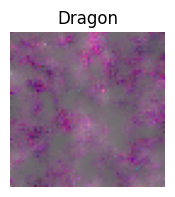

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 912ms/step - loss: 0.0566
Epoch 871/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0111
Epoch 872/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0182
Epoch 873/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0726
Epoch 874/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0169
Epoch 875/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0154
Epoch 876/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0142
Epoch 877/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0127
Epoch 878/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0102
Epoch 879/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0125
Epoch 880/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0079Epoch 880: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.57it/s]


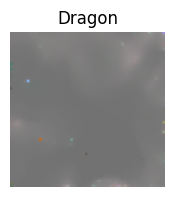

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0074
Epoch 881/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0081
Epoch 882/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0099
Epoch 883/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0125
Epoch 884/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0165
Epoch 885/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0090
Epoch 886/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0085
Epoch 887/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0071
Epoch 888/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0078
Epoch 889/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0059
Epoch 890/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0087Epoch 890: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.70it/s]


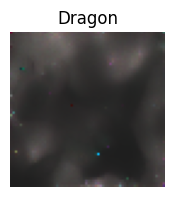

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0082
Epoch 891/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0192
Epoch 892/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0215
Epoch 893/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0198
Epoch 894/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0589
Epoch 895/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0259
Epoch 896/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0267
Epoch 897/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0140
Epoch 898/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0167
Epoch 899/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0096
Epoch 900/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0289Epoch 900: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.64it/s]


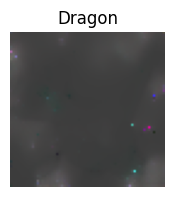

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0272
Epoch 901/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0237
Epoch 902/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0204
Epoch 903/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0248
Epoch 904/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0844
Epoch 905/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0571
Epoch 906/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0437
Epoch 907/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0197
Epoch 908/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0300
Epoch 909/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0157
Epoch 910/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0143Epoch 910: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.61it/s]


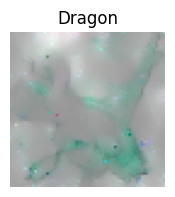

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.0135
Epoch 911/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0104
Epoch 912/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0352
Epoch 913/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0156
Epoch 914/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0287
Epoch 915/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0345
Epoch 916/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0179
Epoch 917/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0100
Epoch 918/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0109
Epoch 919/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0095
Epoch 920/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0106Epoch 920: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.24it/s]


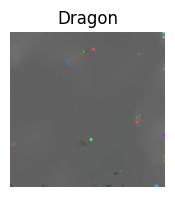

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.0099
Epoch 921/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0063
Epoch 922/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0087
Epoch 923/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0107
Epoch 924/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0123
Epoch 925/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0074
Epoch 926/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0209
Epoch 927/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0088
Epoch 928/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0175
Epoch 929/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0203
Epoch 930/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0171Epoch 930: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.98it/s]


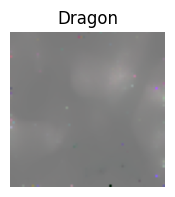

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - loss: 0.0161
Epoch 931/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0311
Epoch 932/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0114
Epoch 933/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0090
Epoch 934/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0108
Epoch 935/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0086
Epoch 936/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0101
Epoch 937/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0124
Epoch 938/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0078
Epoch 939/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0079
Epoch 940/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0212Epoch 940: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.77it/s]


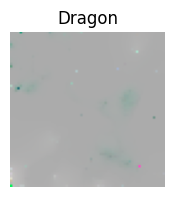

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - loss: 0.0200
Epoch 941/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0386
Epoch 942/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.2430
Epoch 943/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0474
Epoch 944/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0139
Epoch 945/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0137
Epoch 946/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0265
Epoch 947/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0120
Epoch 948/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0404
Epoch 949/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0350
Epoch 950/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0198Epoch 950: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.91it/s]


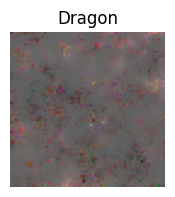

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - loss: 0.0187
Epoch 951/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0334
Epoch 952/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0336
Epoch 953/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0584
Epoch 954/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1357
Epoch 955/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0756
Epoch 956/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0419
Epoch 957/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0487
Epoch 958/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0120
Epoch 959/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0260
Epoch 960/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0325Epoch 960: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.12it/s]


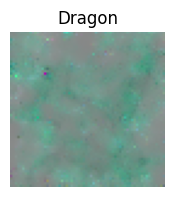

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - loss: 0.0306
Epoch 961/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0287
Epoch 962/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0759
Epoch 963/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0436
Epoch 964/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0143
Epoch 965/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0312
Epoch 966/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0334
Epoch 967/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0130
Epoch 968/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0370
Epoch 969/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.2057
Epoch 970/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1224Epoch 970: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.78it/s]


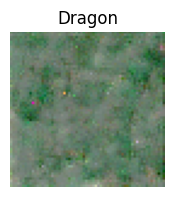

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 906ms/step - loss: 0.1152
Epoch 971/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0593
Epoch 972/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0272
Epoch 973/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0246
Epoch 974/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0105
Epoch 975/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0194
Epoch 976/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0211
Epoch 977/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0093
Epoch 978/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0332
Epoch 979/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0503
Epoch 980/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0573Epoch 980: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.00it/s]


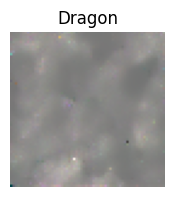

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - loss: 0.0539
Epoch 981/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0684
Epoch 982/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0356
Epoch 983/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0084
Epoch 984/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0114
Epoch 985/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0105
Epoch 986/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0085
Epoch 987/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0123
Epoch 988/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0499
Epoch 989/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1529
Epoch 990/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0439Epoch 990: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.99it/s]


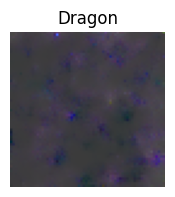

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 897ms/step - loss: 0.0413
Epoch 991/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0266
Epoch 992/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0533
Epoch 993/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0110
Epoch 994/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0195
Epoch 995/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0245
Epoch 996/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0419
Epoch 997/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0631
Epoch 998/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0276
Epoch 999/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0242
Epoch 1000/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0325Epoch 1000: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.98it/s]


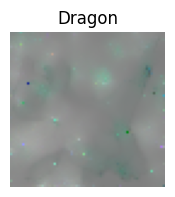

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 900ms/step - loss: 0.0306


In [77]:
model.fit(
    dataset_example,
    epochs=1000,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

In [ ]:
# model.fit(
#     dataset_example,
#     epochs=200,
#     callbacks=[DiffusionCallback(model, 10, str_label_example)],
# )

Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.71it/s]


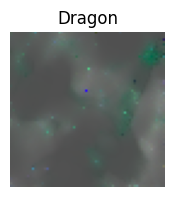

In [79]:
model.plot_samples(1, str_label_example)

Generating sample 1/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.73it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.80it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.35it/s]


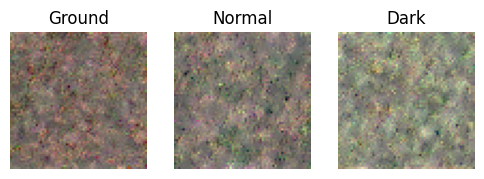

In [80]:
model.plot_samples(3)

In [86]:
# save model
# =====================================================================
# model.save(f"{PROJECT_DIR}/models/test_1.h5")

In [91]:
# model = tf.keras.models.load_model(f"{PROJECT_DIR}/models/test_1.h5")

ValueError: Unknown layer: 'DiffusionModel'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)